In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
import sys 
# sys.path.clear()
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\python36.zip')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\DLLs')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib\\site-packages')
sys.path.insert(0, '')

In [1]:
import sys
sys.path

['/Users/litos/Desktop/thesis/Critiques Draft',
 '/Users/litos/opt/anaconda3/lib/python37.zip',
 '/Users/litos/opt/anaconda3/lib/python3.7',
 '/Users/litos/opt/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/Users/litos/opt/anaconda3/lib/python3.7/site-packages',
 '/Users/litos/opt/anaconda3/lib/python3.7/site-packages/aeosa',
 '/Users/litos/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/litos/.ipython']

In [2]:
sys.path = ['', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python36.zip', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/lib-dynload', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages']

In [3]:
from gurobipy import *

ModuleNotFoundError: No module named 'gurobipy'

In [4]:
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
from sklearn.preprocessing import normalize
from collections import *
import datetime
import json
import pandas as pd
import time
# import yaml
import scipy.sparse as sparse
from ast import literal_eval

import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge
from sklearn.utils.extmath import randomized_svd

from scipy.optimize import minimize

# Load Data

In [6]:
# Load Original Data
df_train = pd.read_csv('../../data/yelp/Train.csv',encoding='latin-1')
# df_valid = pd.read_csv('../../data/yelp/Valid.csv',encoding='latin-1')
# df_test = pd.read_csv('../../data/yelp/Test.csv',encoding='latin-1')

In [7]:
keyphrases = pd.read_csv('../../data/yelp/KeyPhrases.csv')['Phrases'].tolist()
keyphrase_popularity = np.loadtxt('../data/yelp/'+'keyphrase_popularity.txt', dtype=int)

# Load U-I Data 
rtrain = load_npz("../../data/yelp/Rtrain.npz")
rvalid = load_npz("../../data/yelp/Rvalid.npz")
rtest = load_npz("../../data/yelp/Rtest.npz")

# Load user/item keyphrase data
U_K = load_npz("../../data/yelp/U_K.npz")
I_K = load_npz("../../data/yelp/I_K.npz")

# Models

In [8]:
# Models
from sklearn.metrics.pairwise import cosine_similarity
def train(matrix_train):
    similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
    return similarity

def get_I_K(df, row_name = 'ItemIndex', shape = (3668,75)):
    rows = []
    cols = []
    vals = []
    for i in tqdm(range(df.shape[0])):
        key_vector = literal_eval(df['keyVector'][i])
        rows.extend([df[row_name][i]]*len(key_vector)) ## Item index
        cols.extend(key_vector) ## Keyword Index
        vals.extend(np.array([1]*len(key_vector)))
    return csr_matrix((vals, (rows, cols)), shape=shape)



def prediction(prediction_score, topK, matrix_Train):

    prediction = []

    for user_index in tqdm(range(matrix_Train.shape[0])):
        vector_u = prediction_score[user_index]
        vector_train = matrix_Train[user_index]
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine(vector_u, vector_train, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)


def sub_routine(vector_u, vector_train, topK=500):

    train_index = vector_train.nonzero()[1]

    vector_u = vector_u

    candidate_index = np.argpartition(-vector_u, topK+len(train_index))[:topK+len(train_index)]
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    return vector_u[:topK]


In [9]:
def predict(matrix_train, k, similarity, item_similarity_en = False):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    """
    prediction_scores = []
    
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores to all users
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        similar_users = vector_u.argsort()[::-1][1:k+1]
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        similar_users_ratings = matrix_train[similar_users].toarray()

        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]

        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    
    return res

def predict_vector(user_index, matrix_train, k, similarity):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    get only user_index row
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    return np.sum(prediction_scores_u, axis=0)
    

In [10]:
# PLREC 
def inhour(elapsed):
    return time.strftime('%H:%M:%S', time.gmtime(elapsed))

def plrec(matrix_train, iteration=4, lamb=80, rank=200, seed=1):
    """
    Function used to achieve generalized projected lrec w/o item-attribute embedding
    :param matrix_train: user-item matrix with shape m*n
    :param iteration: number of power iterations in randomized svd
    :param lamb: parameter of penalty
    :param rank: latent dimension size
    :param seed: the seed of the pseudo random number generator to use when shuffling the data
    :return: prediction in sparse matrix
    """
    print ("Randomized SVD")
    start_time = time.time()
    P, sigma, Qt = randomized_svd(matrix_train,
                                  n_components=rank,
                                  n_iter=iteration,
                                  random_state=seed)

    RQ = matrix_train.dot(sparse.csc_matrix(Qt.T*np.sqrt(sigma)))

    print("Elapsed: {}".format(inhour(time.time() - start_time)))

    print ("Closed-Form Linear Optimization")
    start_time = time.time()
    pre_inv = RQ.T.dot(RQ) + lamb * sparse.identity(rank, dtype=np.float32)
    inverse = sparse.linalg.inv(pre_inv.tocsc())
    Y = inverse.dot(RQ.T).dot(matrix_train)
    print("Elapsed: {}".format(inhour(time.time() - start_time)))

    return np.array(RQ.todense()), np.array(Y.todense()), None

def predict_vector(rating_vector, train_vector, remove_train=True):
    dim = len(rating_vector)
    candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
    prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]
    
    if remove_train:
        return np.delete(prediction_items, np.isin(prediction_items, train_vector.nonzero()[1]).nonzero()[0])
    else:
        return prediction_items

    
    
def predict_scores(matrix_U, matrix_V, bias=None,
                   penalize = False,
                   keyphrase_freq = I_K, 
                   critiqued_keyphrase = 0, 
                   matrix_Train = rtrain,
                   alpha = 0):
    prediction = matrix_U.dot(matrix_V.T)
    # Penalize
    if penalize == True:
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
        prediction[items_without_keyphrase] = alpha # penalize
    
    return prediction


# Evaluation

In [11]:
# Evluation 
def recallk(vector_true_dense, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_true_dense)

def precisionk(vector_predict, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_predict)


def average_precisionk(vector_predict, hits, **unused):
    precisions = np.cumsum(hits, dtype=np.float32)/range(1, len(vector_predict)+1)
    return np.mean(precisions)


def r_precision(vector_true_dense, vector_predict, **unused):
    vector_predict_short = vector_predict[:len(vector_true_dense)]
    hits = len(np.isin(vector_predict_short, vector_true_dense).nonzero()[0])
    return float(hits)/len(vector_true_dense)


def _dcg_support(size):
    arr = np.arange(1, size+1)+1
    return 1./np.log2(arr)


def ndcg(vector_true_dense, vector_predict, hits):
    idcg = np.sum(_dcg_support(len(vector_true_dense)))
    dcg_base = _dcg_support(len(vector_predict))
    dcg_base[np.logical_not(hits)] = 0
    dcg = np.sum(dcg_base)
    return dcg/idcg


def click(hits, **unused):
    first_hit = next((i for i, x in enumerate(hits) if x), None)
    if first_hit is None:
        return 5
    else:
        return first_hit/10


def evaluate(matrix_Predict, matrix_Test, metric_names =['R-Precision', 'NDCG', 'Precision', 'Recall', 'MAP'], atK = [5, 10, 15, 20, 50], analytical=False):
    """
    :param matrix_U: Latent representations of users, for LRecs it is RQ, for ALSs it is U
    :param matrix_V: Latent representations of items, for LRecs it is Q, for ALSs it is V
    :param matrix_Train: Rating matrix for training, features.
    :param matrix_Test: Rating matrix for evaluation, true labels.
    :param k: Top K retrieval
    :param metric_names: Evaluation metrics
    :return:
    """
    global_metrics = {
        "R-Precision": r_precision,
        "NDCG": ndcg,
        "Clicks": click
    }

    local_metrics = {
        "Precision": precisionk,
        "Recall": recallk,
        "MAP": average_precisionk
    }

    output = dict()

    num_users = matrix_Predict.shape[0]

    for k in atK:

        local_metric_names = list(set(metric_names).intersection(local_metrics.keys()))
        results = {name: [] for name in local_metric_names}
        topK_Predict = matrix_Predict[:, :k]

        for user_index in tqdm(range(topK_Predict.shape[0])):
            vector_predict = topK_Predict[user_index]
            if len(vector_predict.nonzero()[0]) > 0:
                vector_true = matrix_Test[user_index]
                vector_true_dense = vector_true.nonzero()[1]
                hits = np.isin(vector_predict, vector_true_dense)

                if vector_true_dense.size > 0:
                    for name in local_metric_names:
                        results[name].append(local_metrics[name](vector_true_dense=vector_true_dense,
                                                                 vector_predict=vector_predict,
                                                                 hits=hits))

        results_summary = dict()
        if analytical:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = results[name]
        else:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = (np.average(results[name]),
                                                              1.96*np.std(results[name])/np.sqrt(num_users))
        output.update(results_summary)

    global_metric_names = list(set(metric_names).intersection(global_metrics.keys()))
    results = {name: [] for name in global_metric_names}

    topK_Predict = matrix_Predict[:]

    for user_index in tqdm(range(topK_Predict.shape[0])):
        vector_predict = topK_Predict[user_index]

        if len(vector_predict.nonzero()[0]) > 0:
            vector_true = matrix_Test[user_index]
            vector_true_dense = vector_true.nonzero()[1]
            hits = np.isin(vector_predict, vector_true_dense)

            # if user_index == 1:
            #     import ipdb;
            #     ipdb.set_trace()

            if vector_true_dense.size > 0:
                for name in global_metric_names:
                    results[name].append(global_metrics[name](vector_true_dense=vector_true_dense,
                                                              vector_predict=vector_predict,
                                                              hits=hits))

    results_summary = dict()
    if analytical:
        for name in global_metric_names:
            results_summary[name] = results[name]
    else:
        for name in global_metric_names:
            results_summary[name] = (np.average(results[name]), 1.96*np.std(results[name])/np.sqrt(num_users))
    output.update(results_summary)

    return output



## Single Step Critiquing Pipline

### Initial Prediction

In [12]:
# KNN initial Prediction
def get_initial_prediction(user,X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100):
    """
    Get the initial knn predictions before critiquing pipelines
    get the linear regression model for critiquing embedding (W_2)
    get the initial user similarity matrix 
    k here is the parameter for KNN
    """
    clf = Ridge(alpha=0.1).fit(X, y)
    similarity = normalize(train(matrix_Train))
    user_item_prediction_score = predict_vector(user, matrix_Train, k, similarity)
    return user_item_prediction_score, clf


In [14]:
# PLREC initial Prediction
def predict_scores(matrix_U, matrix_V, bias=None,
                   penalize = False,
                   keyphrase_freq = I_K, 
                   critiqued_keyphrase = 0, 
                   matrix_Train = rtrain,
                   alpha = 0):
    
    prediction = matrix_U.dot(matrix_V.T)
    # Penalize
    if penalize == True:
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
        prediction[items_without_keyphrase] = alpha # penalize
    
    return prediction


### Forward predict

Predict a single row (for single user)

In [15]:
# KNN

def predict_vector(user_index, matrix_train, k, similarity):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    get only user_index row
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    return np.sum(prediction_scores_u, axis=0)
    

def predict_vector(user_index, matrix_train, k, similarity, with_keyphrase = False, 
                   keyphrase_freq = None, critiqued_keyphrase = None, alpha = 0):
    """
    get only user_index row
    if with_keyphrase = True, then penalize items without critiqued_keyphrase to alpha (default = 0)
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    if with_keyphrase == False:
        return np.sum(prediction_scores_u, axis=0)
    
    # Only Predict items with critiqued_keyphrase 
    else:
        prediction_scores = np.sum(prediction_scores_u, axis=0)
#         print (prediction_scores)
        #penalize items without critiqued keyphrase
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
#         print (items_with_keyphrase)
        #Return the unique values in ar1 that are not in ar2.
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_train.shape[1]), items_with_keyphrase)
        prediction_scores[items_without_keyphrase] = alpha # penalize
        return prediction_scores
#         print (prediction_scores)
#         return prediction_scores/sum(prediction_scores)


In [16]:
# PLREC
def predict_vector(rating_vector, train_vector, remove_train=True):
    dim = len(rating_vector)
    candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
    prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]
    
    if remove_train:
        return np.delete(prediction_items, np.isin(prediction_items, train_vector.nonzero()[1]).nonzero()[0])
    else:
        return prediction_items


### Keyphrase Selection

In [17]:
def get_valid_keyphrases(keyphrase_freq,top_recommendations,item = None,threshold=50,mutiple_keyphrases_en = False, top_items = None):
    """
    Wrapper function to get either top 1 or top n keyphrases
    """
    if mutiple_keyphrases_en:
        top_keyphrases = []
        for item in top_items:
            top_keyphrases.extend(get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations,item,threshold=threshold))
        return np.ravel(list(set(top_keyphrases))) # remove duplicate and reformat to np array
    else:
        return get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations,item,threshold=threshold)

def get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations, item,threshold=50):
    """
    Get keyphrases of item that make sense
    E.g. if the item has fewer than threshold=50 keyphrases, get all of them
    otherwise get top 50 keyphrases
    """
    keyphrase_length = len(keyphrase_freq[item].nonzero()[1])
    if keyphrase_length<threshold:
        return keyphrase_freq[item].nonzero()[1]
    else:
        keyphrases = np.ravel(keyphrase_freq[top_recommendations[0]].todense())
        top_keyphrases = np.argsort(keyphrases)[::-1][:threshold]
        return top_keyphrases
    
# For keyphrase selecting method # 3 "diff" 
def get_item_keyphrase_freq(keyphrase_freq,item):
    """
    Get item's keyphrase frequency 
    """
    count = keyphrase_freq[item].todense()
    return count/np.sum(count)

def get_keyphrase_popularity(df,keyphrases):
    """
    Get keyphrase popularity (count) from dataframe
    """
    keyphrase_popularity = np.zeros(len(keyphrases)) #initialize
    for i in range(len(df)):
        keyphrase_vector = literal_eval(df['keyVector'][i])
        keyphrase_popularity[keyphrase_vector] += 1 # count
    return keyphrase_popularity

### Critiquing Methods

In [18]:
# One hot encoding of critiquing
def get_critiqued_UK(user_keyphrase_frequency,user_index,critiqued_keyphrase):
    """
    user_keyphrase_frequency is the U_K matrix (csr sparse matrix)
    return the one-hot encoding of the critique
    """
    U_K_cp = user_keyphrase_frequency.copy()
    U_K_cp[user_index] = 0
    U_K_cp[user_index,critiqued_keyphrase] = 1
    return U_K_cp

def project_one_hot_encoding(reg, user_keyphrase_frequency,user_index = 0,critiqued_keyphrase = 0, normalize_en = True):
    """
    Return the projection on user_sim space from one-hot encoding of critiqued keyphrase
    The res[user_index] should be target embedding row
    """
    critiqued_matrix = get_critiqued_UK(user_keyphrase_frequency, user_index, critiqued_keyphrase)
    res = reg.predict(critiqued_matrix)
    if normalize_en:
        res = normalize((res))
    return res

In [19]:
# Upper bound method 
def get_all_affected_items(wanted_keyphrases,keyphrase_freq):
    res = []
    for keyphrase in wanted_keyphrases:
        items = np.ravel(keyphrase_freq.T[keyphrase].nonzero()[1])
        res.extend(items)
    return np.array(list(set(res)))
    
def select_only_wanted_keyphrase(top_recommendations, wanted_keyphrases, keyphrase_freq, matrix_Train = rtrain):
    all_items_with_keyphrases = get_all_affected_items(wanted_keyphrases,keyphrase_freq)
    affected_items = np.setdiff1d(np.arange(matrix_Train.shape[1]), all_items_with_keyphrases) # Get all other keyphrases
    top_recommendations[~np.in1d(top_recommendations, affected_items)]
    return top_recommendations

def pruning(prediction_score, 
           wanted_keyphrases_random, 
           top_recommendations, 
           keyphrase_freq, 
           matrix_Train = rtrain,
           alpha = 0):
    items_with_keyphrase = get_all_affected_items(wanted_keyphrases_random, keyphrase_freq)
    #Return the unique values in ar1 that are not in ar2.
    items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
#     print (items_without_keyphrase)
    print (sum(prediction_score[items_without_keyphrase]))
    score = np.copy(prediction_score)
    score[items_without_keyphrase] = alpha # penalize
    return score

### Utilities

In [20]:
# Utility function for getting restaurant info from ItemIndex
def get_business_df(path = "../../data/yelp/business.json" ):
    with open(path,encoding="utf8") as json_file:
        data = json_file.readlines()
        data = list(map(json.loads, data))
    df = pd.DataFrame(data)
    
    return df

def get_restaurant_info(business_df, business_id, name = True, review_count = True, stars = True ):
    output_list = {}
    row_idx = int(business_df.index[business_df['business_id'] == business_id].tolist()[0])
    if name == True:
        output_list['name'] = business_df['name'][row_idx].encode('utf-8').strip()
    if review_count == True:
        output_list['review_count'] = business_df['review_count'][row_idx]
    if stars == True:
        output_list['stars'] = business_df['stars'][row_idx] 
    return output_list

# def get_businessid_from_Itemindex(ItemIndex_list, itemindex):
#     return ItemIndex_list['business_id'].tolist()[itemindex]

def get_restaurant_name(df_train, business_df, ItemIndex):
    rows = np.where(df_train['ItemIndex'] == ItemIndex)
    if len(rows)!= 0:
        business_id = df_train.loc[rows[0][0]]['business_id']
        item_info = get_restaurant_info(business_df, business_id)
        return item_info['name']
    return "NOT_FOUND"

### Experiment Function

In [21]:
business_df = get_business_df()

In [22]:
Y, RQt, Bias = plrec(rtrain,
                    iteration = 10,
                    lamb = 200,
                    rank = 200)
RQ = RQt.T
reg = LinearRegression().fit(normalize(U_K), Y)

Randomized SVD
Elapsed: 00:00:00
Closed-Form Linear Optimization
Elapsed: 00:00:00


In [23]:
# Set up dataframe 

# post_ranki is post rank with different lambda ratio for combining pre-post User similarity matrix 

columns = ['user_id', 'target_item', 'item_name', 'iter', 'pre_rank', 
           'top_prediction_item_name',
           'post_rank_random_all',
           'post_rank_random_upper',
           'random_scores',
           'post_rank_pop_all',
           'post_rank_pop_upper',
           'pop_scores',
           'post_rank_diff_all',
           'post_rank_diff_upper',
           'diff_scores',
           'critiqued_keyphrase_random',
           'keyphrase_name_random',
           'critiqued_keyphrase_pop',
           'keyphrase_name_pop',
           'critiqued_keyphrase_diff',
           'keyphrase_name_diff',
           'num_existing_keyphrases',
           'pure_pruning_rank'] 
df = pd.DataFrame(columns=columns)
row = {}

In [49]:
def single_step_critiquing_plrec(user = 2, 
                           keyphrase_length_threshold = 150, 
                           max_iteration_threshold = 5,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity, 
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all',
                           lams = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                           reg = reg, Y = Y, RQt = RQt, Bias = Bias,
                           top_k_rec = 20, affected_weight = 1, unaffected_weight = -1,
                                 w1 = 1, w2 = 1
                          ):
    """
    k: HR@k 
    keyphrase_length_threshold: limit the number of keyphrases in top recommended item
    keyphrase_selection_method: 'random': randomly select keyphrase from wanted_keyphrases
                                'pop': always select the most popular keyphrase in wanted_keyphrases
                                'diff': select the keyphrase with largest frequency difference between top recommended 
                                        item and target item.
    recommend_type: 'all': recommend all items
                    'upper' (only_with_critiqued_keyphrase): recommend items with only critiqued_keyphrase
    lam: modified_matrix = lam*origianl_matrix + (1-lam)*critiquing_embedding 
    """
    
    row['user_id'] = user
    print ('User ID ', user)
    
    # Set up (move to header line later)
    matrix_Train = rtrain
    matrix_Test = rtest
    keyphrase_freq = I_K
    num_items = rtrain.shape[1]
    max_wanted_keyphrase = 10 # for keyphrase_selection_method == "diff"
    initial_user_similarity_embedding = normalize(train(matrix_Train))
    
    # Get wanted items 
    candidate_items = matrix_Test[user].nonzero()[1]
    train_items = matrix_Train[user].nonzero()[1]
    wanted_items = np.setdiff1d(candidate_items, train_items)
    print ('wanted_items length: ',len(wanted_items))
    
    # Get initial forward prediction 
    prediction_score = predict_scores(matrix_U=RQ,
                                      matrix_V=Y,
                                      bias=Bias).T[user]
    prediction_items = predict_vector(rating_vector=prediction_score,
                                                              train_vector=matrix_Train[user],
                                                              remove_train=True)
    # Get initial top recommended item(s)
    top_recommendations = np.argsort(prediction_score)[::-1]
    print ("Initial top recommendation index",top_recommendations[0])
    try:
        row['top_prediction_item_name'] = get_restaurant_name(df_train, business_df, top_recommendations[0])
    except: 
        row['top_prediction_item_name'] = 'CANNOT_FIND'
        print ('Cannot get restaurant name for ItemIndex: ', top_recommendations[0])
    
    
    # Get top recommended item's keyphrases
    top_item = top_recommendations[0] 
    top_recommend_keyphrases = get_valid_keyphrases(keyphrase_freq,
                                                    top_recommendations, 
                                                    item = top_item,
                                                    threshold=keyphrase_length_threshold,
                                                    mutiple_keyphrases_en = False, 
                                                    top_items = None)
    top_recommended_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = top_item)
    
    
    #####################################
    # For each item, do the critiquing
    
    #limit the item to only 10
    num_target_item = 0 # initialize item count
    
    for item in wanted_items:    
        print ('target_item: ', item)
        row['target_item'] = item
        try:
            row['item_name'] = get_restaurant_name(df_train, business_df, item)
        except:
            row['item_name'] = 'CANNOT_FIND'
            print ('Cannot get restaurant name for ItemIndex: ', item)

        # Get pre-critiquing rank
        initial_rank = np.where(item == np.argsort(prediction_score)[::-1])[0][0]
        row['pre_rank'] = int(initial_rank)

        # Get the target item's existing keyphrases
        item_keyphrases = keyphrase_freq[item].nonzero()[1]
        
        # For diff 
        target_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = item)
        diff_keyphrase_freq = target_keyphrase_freq - top_recommended_keyphrase_freq
        
        wanted_keyphrases_random = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_pop = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_diff = np.argsort(np.ravel(diff_keyphrase_freq))[::-1][:max_wanted_keyphrase]
        
        pruned_prediction_score = pruning(prediction_score, 
                                           wanted_keyphrases_random, 
                                           top_recommendations, 
                                           keyphrase_freq, 
                                           matrix_Train = rtrain)
        pure_pruning_rank = np.where(item == np.argsort(pruned_prediction_score)[::-1])[0][0]
        if pure_pruning_rank>initial_rank:
            pure_pruning_rank = initial_rank
        row['pure_pruning_rank'] = int(pure_pruning_rank)    
        
        affected_items = np.array([])
        modified_matrix = initial_user_similarity_embedding # initialize user similarity embedding
        
        #############################################
        # Critiquing iteration
        for iteration in range(max_iteration_threshold):
            print ('cur_iter ', iteration)
            row['iter'] = iteration

            if len(wanted_keyphrases_random) == 0 or len(wanted_keyphrases_diff) == 0: 
                print ('no more keyphrase available')
                break
            critiqued_keyphrase_random = np.random.choice(wanted_keyphrases_random, size=1, replace=False)[0]
            critiqued_keyphrase_pop = wanted_keyphrases_pop[np.argmin(keyphrase_popularity[wanted_keyphrases_pop])] # Select the least popular
            critiqued_keyphrase_diff = wanted_keyphrases_diff[0]
            
            row['critiqued_keyphrase_random'] = critiqued_keyphrase_random
            row['keyphrase_name_random'] = keyphrases[critiqued_keyphrase_random]
            row['critiqued_keyphrase_pop'] = critiqued_keyphrase_pop
            row['keyphrase_name_pop'] = keyphrases[critiqued_keyphrase_pop]
            row['critiqued_keyphrase_diff'] = critiqued_keyphrase_diff
            row['keyphrase_name_diff'] = keyphrases[critiqued_keyphrase_diff]
            
            # Do not critique this keyphrase next time
            wanted_keyphrases_random = np.delete(wanted_keyphrases_random, np.where(critiqued_keyphrase_random == wanted_keyphrases_random))
            wanted_keyphrases_pop = np.delete(wanted_keyphrases_pop, np.where(critiqued_keyphrase_pop == wanted_keyphrases_pop))
            wanted_keyphrases_diff = np.delete(wanted_keyphrases_diff, np.where(critiqued_keyphrase_diff == wanted_keyphrases_diff))
            
            # Critiquing Embedding

            # One hot encoding
            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_random =critiqued_matrix

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_pop)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_pop = critiqued_matrix

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_diff)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_diff = critiqued_matrix


            # Warning!!! The following is used only for testing single step critiquing, 
            # for full average critiquing, use the above commented line 
            post_ranks_random_all = []
            post_ranks_random_upper = []
            random_scores = []
            random_ratings = []
            post_ranks_pop_all = []
            post_ranks_pop_upper = []
            pop_scores = []
            pop_ratings = []
            post_ranks_diff_all = []
            post_ranks_diff_upper = []
            diff_scores = []
            diff_ratings = []
            
            num_items = matrix_Train.shape[1]
            affected_items_random = keyphrase_freq[:,critiqued_keyphrase_random].nonzero()[0]
            affected_items_pop = keyphrase_freq[:,critiqued_keyphrase_pop].nonzero()[0]
            affected_items_diff = keyphrase_freq[:,critiqued_keyphrase_diff].nonzero()[0]
            
            unaffected_items_random = np.setdiff1d(range(num_items), affected_items_random)
            unaffected_items_pop = np.setdiff1d(range(num_items), affected_items_pop)
            unaffected_items_diff = np.setdiff1d(range(num_items), affected_items_diff)
            
            for lam in lams:
                modified_matrix_random = (1-lam)*Y + lam*critiqued_matrix_random 
                modified_matrix_pop = (1-lam)*Y + lam*critiqued_matrix_pop 
                modified_matrix_diff = (1-lam)*Y + lam*critiqued_matrix_diff 
                
                # Random
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_random_all.append(item_rank)
                
                # Random scores
                affected_hit = sum(np.in1d(prediction_items[:top_k_rec],affected_items_random))
                unaffected_hit = sum(np.in1d(prediction_items[:top_k_rec],unaffected_items_random))
                score = affected_weight*affected_hit + unaffected_weight*unaffected_hit
                random_scores.append(score)
                
                # Random Rating
                latent_diff = modified_matrix_random - Y #post-pre
                rating_diff = predict_scores(matrix_U=latent_diff[user], 
                                     matrix_V=RQ,
                                     )
                affected_items_mask = np.in1d(prediction_items, affected_items_random)
                affected_items_index_rank = np.where(affected_items_mask == True)
                unaffected_items_index_rank = np.where(affected_items_mask == False)
                
                rating_diff_sum_unaffected = np.sum(np.abs(rating_diff), 
                                                    where = np.in1d(range(num_items),np.intersect1d(unaffected_items_random, prediction_items[unaffected_items_index_rank[0][:100]])))
                rating_diff_sum_affected = np.sum(rating_diff, where = np.in1d(range(num_items), 
                                                                               np.intersect1d(affected_items_random, prediction_items[affected_items_index_rank[0][:100]])))
                rating_score = w1*rating_diff_sum_unaffected - w2*rating_diff_sum_affected
#                 print (rating_score)
                random_ratings.append(rating_score)
    
                # Random upper 
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_random, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_random_upper.append(item_rank)
                
                # Pop
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_pop_all.append(item_rank)
                
                
                # pop scores
                affected_hit = sum(np.in1d(prediction_items[:top_k_rec],affected_items_pop))
                unaffected_hit = sum(np.in1d(prediction_items[:top_k_rec],unaffected_items_pop))
                score = affected_weight*affected_hit + unaffected_weight*unaffected_hit
                pop_scores.append(score)
            
                # Pop Rating
                latent_diff = modified_matrix_pop - Y #post-pre
                rating_diff = predict_scores(matrix_U=latent_diff[user], 
                                     matrix_V=RQ,
                                     )
                affected_items_mask = np.in1d(prediction_items, affected_items_pop)
                affected_items_index_rank = np.where(affected_items_mask == True)
                unaffected_items_index_rank = np.where(affected_items_mask == False)
                
                rating_diff_sum_unaffected = np.sum(np.abs(rating_diff), where = np.in1d(range(num_items),np.intersect1d(unaffected_items_pop, prediction_items[unaffected_items_index_rank[0][:100]])))
                rating_diff_sum_affected = np.sum(rating_diff, where = np.in1d(range(num_items), np.intersect1d(affected_items_pop, prediction_items[affected_items_index_rank[0][:100]])))
                rating_score = w1*rating_diff_sum_unaffected - w2*rating_diff_sum_affected
                pop_ratings.append(rating_score)
                
                # Pop upper 
                
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_pop, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_pop_upper.append(item_rank)
                
                # Diff
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_diff_all.append(item_rank)
                
                # Diff scores
                affected_hit = sum(np.in1d(prediction_items[:top_k_rec],affected_items_diff))
                unaffected_hit = sum(np.in1d(prediction_items[:top_k_rec],unaffected_items_diff))
                score = affected_weight*affected_hit + unaffected_weight*unaffected_hit
                diff_scores.append(score)
                
                # Diff Rating
                latent_diff = modified_matrix_diff - Y #post-pre
                rating_diff = predict_scores(matrix_U=latent_diff[user], 
                                     matrix_V=RQ,
                                     )
                affected_items_mask = np.in1d(prediction_items, affected_items_diff)
                affected_items_index_rank = np.where(affected_items_mask == True)
                unaffected_items_index_rank = np.where(affected_items_mask == False)
                
                rating_diff_sum_unaffected = np.sum(np.abs(rating_diff), where = np.in1d(range(num_items),np.intersect1d(unaffected_items_diff, prediction_items[unaffected_items_index_rank[0][:100]])))
                rating_diff_sum_affected = np.sum(rating_diff, where = np.in1d(range(num_items), np.intersect1d(affected_items_diff, prediction_items[affected_items_index_rank[0][:100]])))
                rating_score = w1*rating_diff_sum_unaffected - w2*rating_diff_sum_affected
                diff_ratings.append(rating_score)
                # Diff upper 
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_diff, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_diff_upper.append(item_rank)
            
            ######################################################
            # optimal predicted lambda from ranking obj 
            random_ranking_opti_predicted = lams[np.argmax(random_scores)]
            pop_ranking_opti_predicted = lams[np.argmax(pop_scores)]
            diff_ranking_opti_predicted = lams[np.argmax(diff_scores)]
            
            # optimal predicted lambda from rating obj 
            random_rating_opti_predicted = lams[np.argmin(random_ratings)]
            pop_rating_opti_predicted = lams[np.argmin(pop_ratings)]
            diff_rating_opti_predicted = lams[np.argmin(diff_ratings)]
            
            ####################################################
            # Get optimal post_ranking predicted
            modified_matrix_random_opti_predicted = (1-random_ranking_opti_predicted)*Y + random_ranking_opti_predicted*critiqued_matrix_random 
            modified_matrix_pop_opti_predicted = (1-random_ranking_opti_predicted)*Y + random_ranking_opti_predicted*critiqued_matrix_pop 
            modified_matrix_diff_opti_predicted = (1-random_ranking_opti_predicted)*Y + random_ranking_opti_predicted*critiqued_matrix_diff 
            # Random
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_random_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['random_opti_ranking'] = item_rank
            
            modified_matrix_random_opti_predicted = (1-random_rating_opti_predicted)*Y + random_rating_opti_predicted*critiqued_matrix_random 
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_random_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['random_opti_rating'] = item_rank
            
            # Pop
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['pop_opti_ranking'] = item_rank
            
            modified_matrix_pop_opti_predicted = (1-pop_rating_opti_predicted)*Y + pop_rating_opti_predicted*critiqued_matrix_pop 
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['pop_opti_rating'] = item_rank
            
            # Diff
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['diff_opti_ranking'] = item_rank
#             print ('diff_opti_ranking ', item_rank)
            
            modified_matrix_diff_opti_predicted = (1-diff_rating_opti_predicted)*Y + diff_rating_opti_predicted*critiqued_matrix_diff 
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['diff_opti_rating'] = item_rank
            
            row['post_rank_random_all'] = post_ranks_random_all
            row['post_rank_random_upper'] = post_ranks_random_upper
            row['random_scores'] = random_scores
            row['random_ratings'] = random_ratings
            
            row['post_rank_pop_all'] = post_ranks_pop_all
            row['post_rank_pop_upper'] = post_ranks_pop_upper
            row['pop_scores'] = pop_scores
            row['pop_ratings'] = pop_ratings
            
            row['post_rank_diff_all'] = post_ranks_diff_all
            row['post_rank_diff_upper'] = post_ranks_diff_upper
            row['diff_scores'] = diff_scores
            row['diff_ratings'] = diff_ratings
            
            df = df.append(row, ignore_index=True)
            

        # break after got 10 target items 
        num_target_item += 1
        if num_target_item >10: # only want max 10 items per user
            break
            
    return df

In [149]:
np.argmax(literal_eval(df['random_scores'][0]))

9

In [25]:
single_step_with_avg_path = '../tables/critiquing/plrec_with_obj/'

In [50]:
# Set up dataframe 

# post_ranki is post rank with different lambda ratio for combining pre-post User similarity matrix 

columns = ['user_id', 'target_item', 'item_name', 'iter', 'pre_rank', 
           'top_prediction_item_name',
           'post_rank_random_all',
           'post_rank_random_upper',
           'random_scores',
           'random_ratings',
           'random_opti_ranking',
           'random_opti_rating',
           'post_rank_pop_all',
           'post_rank_pop_upper',
           'pop_scores',
           'pop_ratings',
           'pop_opti_ranking',
           'pop_opti_rating',
           'post_rank_diff_all',
           'post_rank_diff_upper',
           'diff_scores',
           'diff_ratings',
           'diff_opti_ranking',
           'diff_opti_rating',
           'critiqued_keyphrase_random',
           'keyphrase_name_random',
           'critiqued_keyphrase_pop',
           'keyphrase_name_pop',
           'critiqued_keyphrase_diff',
           'keyphrase_name_diff',
           'num_existing_keyphrases',
           'pure_pruning_rank'] 
df = pd.DataFrame(columns=columns)
row = {}

#only_with_critiqued_keyphrase
for user in range(300,350):
    df = single_step_critiquing_plrec(user = user, 
                           keyphrase_length_threshold = 230, 
                           max_iteration_threshold = 10,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity,
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all',
                           top_k_rec=100
                           )
df.to_csv(single_step_with_avg_path+"ranking_and_rating_50user_optimal_included.csv")

User ID  300
wanted_items length:  14
Initial top recommendation index 5010
target_item:  101
41.544414114716346
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  886
17.15062284177111
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  968
16.47581896918564
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1620
140.59583212701546
cur_iter  0
no more keyphrase available
target_item:  1898
10.686736359377392
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2803
11.87170214222715
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3822
131.2818960825971
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  4025
44.43968693098577
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  4906
28.51678266046656
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5041
11.519449157189229
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5098
8.70338155420177
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  301
wanted_items length:  0
Initial top recommendation index 7455
User ID  302
wanted_items length:  7
Initial top recommendation index 2804
target_item:  1833
115.2953798038252
cur_iter  0
no more keyphrase available
target_item:  2286
21.131997340427915
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2810
40.394062391711486
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  4091
30.837981232438324
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4216
21.714283244164108
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4499
23.539536897525977
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5040
18.72463711000819
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  303
wanted_items length:  7
Initial top recommendation index 1406
target_item:  38
8.09358193983553
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1199
9.765911905952635
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3368
8.21230263087682
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4432
17.631123209773705
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  5659
5.192703764769249
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6023
10.36838437261531
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6990
10.106503969855567
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  304
wanted_items length:  10
Initial top recommendation index 6454
target_item:  1483
55.63940756380134
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  1985
32.2619852881262
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  3158
68.55928420094233
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  4323
2.394275938518149
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5081
1.0547012167107823
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5710
123.45372508457467
cur_iter  0
no more keyphrase available
target_item:  6222
13.67697322107324
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6323
16.192987892999554
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6708
16.493156750037997
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7163
3.262237164018188
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  305
wanted_items length:  15
Initial top recommendation index 3377
target_item:  39
6.28777008754696
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1890
24.091915121995044
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1985
7.123070193976673
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2589
8.522417081869207
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2780
16.44225250272393
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3598
11.082065955474718
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3850
14.023018677957225
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4238
12.25854317671292
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4299
54.6439944127369
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  4772
8.74051236845844
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5364
5.720303037245685
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  306
wanted_items length:  9
Initial top recommendation index 5410
target_item:  647
21.557859250633328
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1340
10.454470912014358
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1488
13.096249822750679
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1562
10.639697891756441
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2039
13.824290231366831
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3554
9.817367573365118
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6454
8.652964081351456
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6772
17.08624232368129
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7286
10.110763720016621
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  307
wanted_items length:  5
Initial top recommendation index 5659
target_item:  1392
42.83656223412072
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  2517
58.4255738837237
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  2841
19.239814215425213
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5147
74.8824115988973
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  5280
28.661252940384657
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
User ID  308
wanted_items length:  25
Initial top recommendation index 5363
target_item:  213
88.89410041617248
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  467
37.03650225590991
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  545
103.59009388666254
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  637
39.19008132070303
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  867
105.19795162863466
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  870
23.843328922499495
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1244
36.45353719609557
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1608
23.831571985541814
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1784
55.95923246296661
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  2055
22.35365326927422
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2089
Cannot get restaurant name for ItemIndex:  2089
60.57292299405981
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
User ID  309
wanted_items length:  13
Initial top recommendation index 1652
target_item:  179
20.426698228108762
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  754
7.658910639147507
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2038
11.06509869105139
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3114
44.025248958952034
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  3139
10.253737620078937
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3247
15.957236290574656
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4072
8.91189648229647
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4707
10.642189533316014
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4828
14.520308970689257
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5377
9.660282569578158
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5471
32.35327982746912
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
User ID  310
wanted_items length:  8
Initial top recommendation index 2446
target_item:  425
96.03770544327506
cur_iter  0
no more keyphrase available
target_item:  754
4.520669449289926
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3072
17.66810866502965
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  3964
14.871176776441644
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  4582
12.442088107748873
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4799
11.573109008075335
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7100
3.5701335168378137
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7445
23.07169413848112
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
User ID  311
wanted_items length:  6
Initial top recommendation index 3997
target_item:  279
3.6932988268463305
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2089
Cannot get restaurant name for ItemIndex:  2089
4.728052205559834
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3229
3.494613359042887
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6437
4.422369961989716
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6735
3.7441837813148595
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7427
3.3181694241775403
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  312
wanted_items length:  9
Initial top recommendation index 6454
target_item:  75
14.670108846645235
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  299
11.118075859039891
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2341
6.331110694945892
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3718
6.7051970014817925
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5144
14.395529343999442
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  5402
8.1644408370895
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5784
8.43345702962506
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6508
22.52788478610921
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6739
8.339530290819312
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  313
wanted_items length:  6
Initial top recommendation index 6688
target_item:  957
29.79583747288507
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
no more keyphrase available
target_item:  1392
7.005493033048424
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1548
3.0847849564643184
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4952
5.3100821481407365
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5478
6.591252339082075
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6717
4.649172835438549
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  314
wanted_items length:  36
Initial top recommendation index 3377
target_item:  20
17.416249928728575
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  42
Cannot get restaurant name for ItemIndex:  42
454.2394997584943
cur_iter  0
no more keyphrase available
target_item:  53
39.15754373705022
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  84
14.08180982130034
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  774
9.658901339631484
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  818
14.58834891591141
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  868
25.45731338346559
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  991
454.2394997584943
cur_iter  0
no more keyphrase available
target_item:  1063
14.983971552481307
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1726
20.160437874832496
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1858
12.34540879173619
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  315
wanted_items length:  12
Initial top recommendation index 5659
target_item:  488
59.324331106807165
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1202
77.69506441187326
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  1218
35.16956783845302
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  2729
20.050842472932345
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3040
45.70931584977916
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  4034
30.35403702743315
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5820
37.961325457772546
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6243
50.6916474141762
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  6258
26.88740038569449
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6437
35.13780323436913
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7037
66.13093431061128
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
User ID  316
wanted_items length:  7
Initial top recommendation index 3347
target_item:  463
13.727177036610556
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  914
23.34433457048999
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1700
15.11369986816635
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2667
12.774704798633252
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4442
10.704803156035837
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5485
9.161863386389996
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5852
13.61680653581891
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  317
wanted_items length:  37
Initial top recommendation index 419
target_item:  278
30.81195115089713
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  612
77.58279411238027
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  711
121.30677842760088
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  1249
23.702762062244346
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1291
28.998669385842277
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1308
39.489871645496805
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1445
24.71571729334164
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1782
47.28304665894939
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1784
37.381081731729864
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1864
99.28758748265864
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1978
146.46540271190497
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
User ID  318
wanted_items length:  5
Initial top recommendation index 4762
target_item:  1528
9.017041911080014
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4115
61.591611226486975
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  5493
51.97167516008017
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  6268
6.633139287604763
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6617
68.4065086521889
cur_iter  0
no more keyphrase available
User ID  319
wanted_items length:  7
Initial top recommendation index 5286
target_item:  39


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


8.549191638155662
cur_iter  0
cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2401
41.98987502620503
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  2641
24.594646990915408
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  3182
11.78226345923531
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3895
22.34205040614097
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  6320
58.290599650235436
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  6454
5.292301215919451
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  320
wanted_items length:  7
Initial top recommendation index 5081
target_item:  68
3.527513013673797
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1288
2.765902456118056
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3083
2.4688066641042496
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3333
3.0817733845033217
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4072
3.374476061642781
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4495
2.2791742664703634
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5577
2.3376413442510966
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  321
wanted_items length:  24
Initial top recommendation index 6454
target_item:  174
33.462671265077915
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  201
17.107432480158423
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  910
48.317320893073884
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  1361
22.541580956893995
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1378
19.210259668178878
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1488
31.43619538069379
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1652
26.126450448092328
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1807
47.410819628449644
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2243
32.1702430349751
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2537
42.41361646085261
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3333
20.695512107557988
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  322
wanted_items length:  18
Initial top recommendation index 43
target_item:  1250
45.010428425401415
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  2147
57.73924976168587
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2446
14.070267241412012
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2449
22.07103074165957
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2942
20.175078485990753
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3301
51.939383577144554
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  3333
16.06886120540753
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3377
26.85070856484913
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3558
77.83857599077987
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  4495
16.37400916496722
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5081
22.41544031467879
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  323
wanted_items length:  7
Initial top recommendation index 3997
target_item:  161
3.3511783447456764
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1218
6.581349408478673
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1490
3.807823326009384
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4383
25.21806167873001
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  4421
4.339014348936871
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5637
90.94447101075639
cur_iter  0
no more keyphrase available
target_item:  6555
5.754710796754807
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  324
wanted_items length:  25
Initial top recommendation index 4443
target_item:  533
57.840464279270236
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  635
71.89009503194029
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  766
118.05658522207887
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  854
79.07658616499612
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1209
55.44591822039001
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1337
147.9644603197048
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  1474
280.90678719104835
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  2031
52.94265027000438
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2509
97.8366545458448
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2894
54.872302457177284
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2923
236.80206468357574
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
User ID  325
wanted_items length:  8
Initial top recommendation index 4972
target_item:  1463
33.012655928849426
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  1567
30.98443755307585
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  2794
11.621537110257805
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2957
7.229763178217581
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4141
6.5363701208420935
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6071
16.935360531669176
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7195
11.06925931451542
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7425
10.299639229914646
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  326
wanted_items length:  13
Initial top recommendation index 5410
target_item:  36
5.603136837402417
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  828
10.847378242091509
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1219
8.153686372788798
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1411
16.59562105432269
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1467
12.470992521615699
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1780
30.10119468953053
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  3264
13.905610474408604
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  3743
24.793710585305234
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  3771
8.090047037490876
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4554
21.96208844477951
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  4673
8.56231707072584
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  327
wanted_items length:  8
Initial top recommendation index 6668
target_item:  95
Cannot get restaurant name for ItemIndex:  95
116.30826236820121
cur_iter  0
no more keyphrase available
target_item:  1044
15.461497416541533
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1644
14.564467683601833
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1955
9.257120016820409
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2889
10.517609660641028
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3339
44.587461297472146
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  5118
7.448638010746436
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7070
10.345757127493016
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  328
wanted_items length:  8
Initial top recommendation index 4443
target_item:  3401
17.396649325775797
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  4011
12.38437177783635
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4820
11.491033591571977
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6167
8.627882112436055
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6288
23.533195622683706
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6864
14.565759796665589
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  6950
Cannot get restaurant name for ItemIndex:  6950
119.28952302080324
cur_iter  0
no more keyphrase available
target_item:  6958
8.694313558620706
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  329
wanted_items length:  14
Initial top recommendation index 6739
target_item:  790
11.657244435000393
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1107
11.383998840739878
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1259
9.256603579427974
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1658
18.470672399140312
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2436
70.0347088308472
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  2643
48.669305409955996
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2653
36.78553431193541
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  2699
69.65718957422268
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  4332
20.88182823373063
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4428
9.056943851230244
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4939
10.094714873832345
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  330
wanted_items length:  5
Initial top recommendation index 201
target_item:  1187
6.19976533414183
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1898
7.455156247887771
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3149
5.407350244036024
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3185
7.6748762049596735
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4831
15.085564015430009
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  331
wanted_items length:  5
Initial top recommendation index 5852
target_item:  3279
9.284364901816843
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4713
34.50686777062242
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  5033
3.457781907145545
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5850
11.167737929628856
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7199
10.351130481459222
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  332
wanted_items length:  0
Initial top recommendation index 7455
User ID  333
wanted_items length:  20
Initial top recommendation index 6222
target_item:  570
7.371665711332753
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  790
7.049124705445138
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1268
10.954714171759406
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1863
8.389039615638467
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1887
22.507021895053185
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  2299
7.439049405857077
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2898
7.387352367310086
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3064
13.846310535005614
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3417
13.082595996926102
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3428
5.802101020872215
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3585
16.815320638979756
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  334
wanted_items length:  8
Initial top recommendation index 4443
target_item:  276
1.9384091181016174
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  535
2.977277880794418
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3416
7.007353976486911
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  3499
1.5843400000228485
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3646
2.426134015560592
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3700
2.7891055686939126
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5972
3.2415388495535353
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7090
31.265495261338174
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
User ID  335
wanted_items length:  9
Initial top recommendation index 3772
target_item:  2013
6.379754104344045
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2573
2.217953541258737
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3983
3.9504652674104364
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4495
2.6158405583646527
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4683
4.182703058765583
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6068
31.06455301165164
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  6302
92.24622359513882
cur_iter  0
no more keyphrase available
target_item:  6815
8.525644574784508
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7303
8.127280485360586
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  336
wanted_items length:  5
Initial top recommendation index 6498
target_item:  593
14.910882108449414
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
no more keyphrase available
target_item:  3198
15.778564176465125
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
no more keyphrase available
target_item:  3337
3.8314112838761503
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6149
9.681240306086465
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  6811
6.6976987967118475
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  337
wanted_items length:  7
Initial top recommendation index 39
target_item:  533
3.2697005527725196
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1043
8.256112128772656
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2964
7.560720078565396
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3185
1.9323880827068933
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3748
1.5227854065742576
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5080
3.8942728912925304
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5288
2.1986856546900526
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  338
wanted_items length:  11
Initial top recommendation index 2729
target_item:  1438
13.00243670305099
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2812
8.843384964755927
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3259
12.245142204661079
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3717
15.327337674421415
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4423
9.54420480984436
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5315
5.719603259548876
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5659
4.936621005759207
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6454
5.2204027075586055
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6776
8.138519089605325
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6975
8.598932653512293
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7205
8.940650259722588
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  339
wanted_items length:  7
Initial top recommendation index 7100
target_item:  38
25.293207514750065
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2630
101.381165792508
cur_iter  0
no more keyphrase available
target_item:  3477
25.73271069207567
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
no more keyphrase available
target_item:  3758
41.55629508909715
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  4442
28.426388156188295
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5424
70.21610874593625
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  6681
20.05210575955698
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  340
wanted_items length:  4
Initial top recommendation index 2804
target_item:  2489
12.263714600587718
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  4417
14.459477307701036
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  5626
5.82007833593525
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6644
5.316555300192704
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  341
wanted_items length:  27
Initial top recommendation index 5081
target_item:  43
4.248720794414112
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  68
8.290051268828392
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  407
14.9326273800325
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  673
4.616954522069136
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  934
8.868788568986929
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1244
9.552609854850743
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1777
5.012333924460108
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2400
7.365938494920556
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2569
6.373436891240999
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2812
12.415149574199859
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3044
5.176112784414727
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  342
wanted_items length:  5
Initial top recommendation index 7137
target_item:  1057
5.763606511845865
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5041
2.754019013100333
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5208
14.56040418583052
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  6509
Cannot get restaurant name for ItemIndex:  6509
62.20131501805804
cur_iter  0
no more keyphrase available
target_item:  7304
62.20131501805804
cur_iter  0
no more keyphrase available
User ID  343
wanted_items length:  49
Initial top recommendation index 6167
target_item:  84


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


57.86124029320763
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  108
127.91964783025742
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  735
44.8820327309395
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  935
32.19784787996741
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  955
57.03546009126421
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1472
71.96619745818589
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1652
28.518937643882055
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1665
145.8871462115303
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  1710
106.63409987395335
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
no more keyphrase available
target_item:  2564
65.7077123486988
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2696
80.22299928326811
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  344
wanted_items length:  41
Initial top recommendation index 4786
target_item:  116
339.5090109180928
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  201
17.178857583610807
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  327
41.50846188745709
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  530
32.29613625582715
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1246
38.78805962829574
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1478
41.44767936192875
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1488
31.459391546130064
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1689
32.92417252561427
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1761
37.89322084160813
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1776
78.07411511465034
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
no more keyphrase available
target_item:  1832
23.632602165685967
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  345
wanted_items length:  8
Initial top recommendation index 6299
target_item:  495
21.91297270391351
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  601
7.664044588068691
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2687
24.7182313001058
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  2788
7.962212846388184
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2847
7.374564328826864
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3211
7.453990407928359
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4566
7.894015566738972
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  7313
5.68704772420665
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  346
wanted_items length:  11
Initial top recommendation index 6776
target_item:  17
10.482355109362743
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  416
11.626652302400089
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1204
6.535916247346449
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3590
10.944093726638584
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3883
6.915687957588943
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3958
28.277288548900742
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4788
9.581885089149637
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5010
6.229060620882137
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5410
7.246406409743486
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5538
18.474765199856392
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5773
74.94024941676935
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
no more keyphrase available
User ID  347
wanted_items length:  49
Initial top recommendation index 2514
target_item:  476
46.84591543427996
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  566
39.897791835033786
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  612
63.22957223169033
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  935
29.983218412691713
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  973
41.36229531933168
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1311
120.45295871245071
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
no more keyphrase available
target_item:  1438
36.98867264495311
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1643
60.79584204951061
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1898
39.759631459795855
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2006
29.880838557515744
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2313
36.14117814529709
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  348
wanted_items length:  5
Initial top recommendation index 2804
target_item:  149
22.56564872347326
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
no more keyphrase available
target_item:  823
9.838244154032509
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2791
7.818321905455832
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3933
8.702713309314731
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6858
7.881005450226439
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
User ID  349
wanted_items length:  8
Initial top recommendation index 2154
target_item:  265
4.498733634829705
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1357
3.9448585771590388
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1621
76.4704951538522
cur_iter  0
no more keyphrase available
target_item:  2855
2.5992305436286642
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3865
3.5022917046173916
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4148
3.6138588959249773
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  4495
3.78595773985694
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  6210
5.580485760507372
cur_iter  0


/Users/litos/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9


In [51]:
df

,user_id,target_item,item_name,iter,pre_rank,top_prediction_item_name,post_rank_random_all,post_rank_random_upper,random_scores,random_ratings,...,diff_opti_ranking,diff_opti_rating,critiqued_keyphrase_random,keyphrase_name_random,critiqued_keyphrase_pop,keyphrase_name_pop,critiqued_keyphrase_diff,keyphrase_name_diff,num_existing_keyphrases,pure_pruning_rank
0,300,101,b'Cabin Fever',0,4830,b'Sansotei Ramen',"[4830, 4739, 4610, 4486, 4284, 3670, 3412, 316...","[6831, 6828, 6810, 6804, 6781, 903, 872, 841, ...","[30, 32, 30, 32, 36, 40, 42, 46, 50, 56, 54]","[0.0, 9.027975089145073, 16.591201696750893, 2...",...,2984,2805,105,latte,155,refill,53,tea,NaN,4830
1,300,101,b'Cabin Fever',1,4830,b'Sansotei Ramen',"[4830, 4870, 4919, 4942, 4934, 4890, 4815, 468...","[7062, 7062, 7064, 7074, 7079, 7070, 7047, 702...","[-26, -20, -16, -14, -10, -8, 4, 4, 6, 12, 20]","[0.0, 9.371879606434273, 17.51011956256211, 20...",...,3001,3001,155,refill,105,latte,153,friendly,NaN,4830
2,300,101,b'Cabin Fever',2,4830,b'Sansotei Ramen',"[4830, 4720, 4589, 4394, 3757, 3473, 3180, 286...","[6685, 6671, 6655, 6630, 1151, 1109, 1060, 100...","[38, 38, 36, 34, 32, 36, 42, 48, 54, 56, 56]","[0.0, 10.242908497664047, 19.00187129953043, 2...",...,2735,2576,37,bread,37,bread,105,latte,NaN,4830
3,300,886,b'Wok & Roast Chinese BBQ',0,3515,b'Sansotei Ramen',"[3515, 4861, 5639, 6199, 6511, 6652, 6711, 671...","[492, 7087, 7148, 7213, 7246, 7269, 7269, 7266...","[-24, -26, -26, -20, -14, -8, -12, -10, -4, -6...","[0.0, 12.012296591615225, 20.873883584041486, ...",...,3973,3871,81,juice,223,general tao,27,bbq,NaN,2442
4,300,886,b'Wok & Roast Chinese BBQ',1,3515,b'Sansotei Ramen',"[3515, 2877, 2365, 2086, 1917, 1813, 1747, 171...","[26, 29, 31, 30, 30, 31, 32, 33, 33, 33, 32]","[-98, -98, -96, -94, -92, -92, -94, -94, -94, ...","[0.0, 10.10873862920019, 20.171239853516084, 3...",...,2652,1840,223,general tao,73,congee,0,chinese,NaN,2442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,349,6210,"b""Osmow's""",5,5581,b'Jim Chai Kee',"[5581, 6143, 6525, 6717, 6774, 6777, 6775, 675...","[7126, 7186, 7247, 7264, 7264, 7263, 7262, 725...","[-4, -4, 8, 4, 16, 24, 22, 26, 26, 24, 18]","[0.0, 8.34193428173412, 13.332088703619092, 13...",...,4087,2891,203,greasy,164,quiet,178,honestly,NaN,5581
3509,349,6210,"b""Osmow's""",6,5581,b'Jim Chai Kee',"[5581, 5427, 5195, 4858, 4302, 3311, 2797, 236...","[6615, 6577, 6525, 6449, 6303, 1291, 1186, 107...","[60, 60, 58, 62, 70, 76, 74, 80, 78, 84, 82]","[0.0, 6.186683190663671, 11.577878061303528, 1...",...,1450,5581,117,rib,173,dark,76,lettuce,NaN,5581
3510,349,6210,"b""Osmow's""",7,5581,b'Jim Chai Kee',"[5581, 5381, 5097, 4694, 4119, 3198, 2738, 239...","[7167, 7158, 7136, 7116, 7089, 423, 399, 370, ...","[-50, -46, -40, -42, -30, -24, -16, -14, -16, ...","[0.0, 6.477634326082224, 11.267076368863448, 1...",...,6688,6688,40,pizza,178,honestly,114,tomato,NaN,5581
3511,349,6210,"b""Osmow's""",8,5581,b'Jim Chai Kee',"[5581, 5103, 4404, 3061, 2375, 1949, 1647, 144...","[7009, 6958, 6897, 676, 599, 524, 463, 426, 39...","[0, 2, 6, 6, 8, 12, 18, 12, 12, 12, 10]","[0.0, 5.840329602906028, 9.273004940589976, 10...",...,6146,5887,91,wrap,91,wrap,161,cheaper,NaN,5581


In [27]:
df['post_rank_random_all'][0]

[4830, 4739, 4610, 4486, 4284, 3670, 3412, 3168, 2935, 2735, 2576]

# Forward

In [29]:
# KNN Forward 
similarity = normalize(train(rtrain))
user_item_prediction_score = predict(rtrain, 100, similarity, item_similarity_en= False)
user_item_predict = prediction(user_item_prediction_score, 50, rtrain)
user_item_res = evaluate(user_item_predict, rtest)

100%|██████████| 2343/2343 [00:00<00:00, 4548.68it/s]


In [30]:
# Evaluation result with k = 100
user_item_res

{'MAP@5': (0.06940666362391602, 0.0060646277121995185),
 'Recall@5': (0.026408137823500974, 0.002191309117794643),
 'Precision@5': (0.06462802373345505, 0.004754606217931856),
 'MAP@10': (0.06333952750429245, 0.00455145183026277),
 'Recall@10': (0.04269615369598775, 0.0027831077562657665),
 'Precision@10': (0.05330899132816066, 0.0032544740534870857),
 'MAP@15': (0.05872249612550844, 0.0038121823597348156),
 'Recall@15': (0.05562887733868642, 0.0031389991916236284),
 'Precision@15': (0.04698006998326487, 0.0025622684368576416),
 'MAP@20': (0.055196280875748356, 0.003345258771111864),
 'Recall@20': (0.0677664821917642, 0.003424484045821138),
 'Precision@20': (0.043336376083979916, 0.002222006808632301),
 'MAP@50': (0.04436838784245958, 0.0022020570312340938),
 'Recall@50': (0.12696642809611336, 0.0048241883971306436),
 'Precision@50': (0.032889091738931994, 0.0014317314500480152),
 'R-Precision': (0.048464138894968055, 0.0027869069242192506),
 'NDCG': (0.09071795198195, 0.00380397059001

In [ ]:
# PLREC Forward


In [ ]:
# PLREC 


In [ ]:
# Learn User-Keyphrase matrix to Latent Embedding
# Training 
X = normalize(U_K.todense())
y = normalize(train(rtrain))
clf = Ridge(alpha=0.1).fit(X, y) # Optimality at L2 regularization = 0.1
lr_similarity = clf.predict(np.array(X))

# Experiment

In [32]:
# keyphrase_popularity = get_keyphrase_popularity(df_train,keyphrases)

# Save and load
# np.savetxt('../data/yelp/'+'keyphrase_popularity.txt', keyphrase_popularity, fmt='%d')
keyphrase_popularity = np.loadtxt('../data/yelp/'+'keyphrase_popularity.txt', dtype=int)

# Testing Gurobi

In [ ]:
# critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
critiqued_matrix_onehot = get_critiqued_UK(U_K,0,0)
critiqued_matrix = reg.predict(critiqued_matrix_onehot)
critiqued_matrix_random =critiqued_matrix

U_V_critique = critiqued_matrix_random
U_V_initial = Y
latent_diff = U_V_critique - U_V_initial

rating_diff = predict_scores(matrix_U=lamb * latent_diff[user], 
                     matrix_V=RQ)
rating_diff_sum_unaffected = np.sum(abs(rating_diff), where = np.in1d(range(num_items),unaffected_items))
rating_diff_sum_affected = np.sum(rating_diff, where = np.in1d(range(num_items),affected_items))
obj = w1*abs(rating_diff_sum_unaffected) + w2*rating_diff_sum_affected 

In [68]:
user = 0
critiqued_keyphrase_random = 0
critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
critiqued_matrix = reg.predict(critiqued_matrix_onehot)
critiqued_matrix_random =critiqued_matrix
modified_matrix_random = critiqued_matrix_random + Y
matrix_Train = rtrain
prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                     matrix_V=RQ,
                                     )
prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                  train_vector=matrix_Train[user],
                                  remove_train=True)

/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [70]:
num_items = rtrain.shape[1]
affected_items = I_K[:, critiqued_keyphrase_random].nonzero()[0]
unaffected_items = np.setdiff1d(range(num_items), affected_items)

In [77]:
prediction_score = predict_scores(matrix_U=RQ,
                                      matrix_V=Y,
                                      bias=Bias).T[user]
# Get initial top recommended item(s)
initial_top_recommendations = np.argsort(prediction_score)[::-1]

sum(np.in1d(initial_top_recommendations[:10], affected_items))

5

In [78]:
sum(np.in1d(prediction_items[:10], affected_items))

7

In [80]:
print (sum(np.in1d(initial_top_recommendations[:10], unaffected_items)))
print (sum(np.in1d(prediction_items[:10], unaffected_items)))

5
3


# LP Model

## Ranking Model

In [ ]:
# 
quicksum(
    initial_prediction_u[affected_item] * num_unaffected_items + 
    quicksum(lambs[k] * critiqued_vector[query[k]] * W[affected_item][query[k]] * num_unaffected_items 
                 for k in range(num_critiques)) for affected_item in affected_items) - 
    quicksum(initial_prediction_u[unaffected_item] * num_affected_items + 
             quicksum(lambs[k] * critiqued_vector[query[k]] * W[unaffected_item][query[k]] * num_affected_items 
                for k in range(num_critiques)) for unaffected_item in unaffected_items)
# maximize rank: 
rank = sum(np.in1d(prediction_items[:10], affected_items))


In [99]:
prediction_scores_u = modified_matrix_random[user].dot(RQ.T)

In [103]:
np.argsort(prediction_scores_u)[::-1]

array([6222, 5410, 2804, ..., 3713, 4582, 7163])

In [166]:
k = 10 # top k precision
user = 0

# modified_matrix_random = lamb*critiqued_matrix_random + (1-lamb)*Y
# prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
#                                      matrix_V=RQ,
#                                      )
# prediction_scores_u = modified_matrix_random[user].dot(RQ.T)
# prediction_items = predict_vector(rating_vector=prediction_scores_u,
#                                   train_vector=matrix_Train[user],
#                                   remove_train=True)
# dim = len(rating_vector)
# candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
# prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]

# prediction_items = np.argsort(prediction_scores_u)[::-1][::k]

# prediction_items = np.argsort((lamb*critiqued_matrix_random + (1-lamb)*Y)[user].dot(RQ.T))[::-1][:k]
# np.in1d(prediction_items,affected_items)
# Model
m = Model("Ranking")
# Assign Variable 
lamb = m.addVar(lb = 0, 
                ub = 1,
                vtype = GRB.CONTINUOUS,
                name = "lamb"
               )
# quicksum(np.in1d(np.argsort(prediction_items)[:10],affected_items))
# Set Objective
m.setObjective(
    quicksum(
             (np.array([lamb*critiqued_matrix_random[0][i] for i in range(len(Y[0]))]) + 
             np.array([(1-lamb)*Y[0][i] for i in range(len(Y[0]))])).dot(RQ.T)
            
            )
, GRB.MINIMIZE)

In [156]:
lamb = 0.1
modified_matrix = np.array([lamb*critiqued_matrix_random[0][i] for i in range(len(Y[0]))]) + np.array([(1-lamb)*Y[0][i] for i in range(len(Y[0]))])

In [161]:
prediction_score = modified_matrix.dot(RQ.T)

In [164]:
np.argsort(prediction_score)[::-1][:10]

array([6222, 5410, 6454, 2804, 5081, 4358, 6299, 6940,  585, 6099])

In [132]:
np.argsort(modified_matrix.dot(RQ.T))[::-1][:10]

array([6222, 5410, 6454, 2804, 5081, 4358, 6299, 6940,  585, 6099])

In [ ]:
m.optimize()
for v in m.getVars():
    print('%s %g' % (v.varName, v.x))
print('Obj: %g' % m.objVal)

In [89]:
# This example formulates and solves the following simple MIP model:
#  maximize
#        x + y + 2 z
#  subject to
#        x + 2 y + 3 z <= 4
#        x +   y       >= 1
#        x, y, z binary

import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("mip1")

# Create variables
x = m.addVar(lb = -1,
             ub = 1,
             vtype=GRB.CONTINUOUS, 
             name="x")
y = m.addVar(vtype=GRB.CONTINUOUS, name="y")
z = m.addVar(vtype=GRB.CONTINUOUS, name="z")

# Set objective
m.setObjective(x + y*3 + 2 * z, GRB.MAXIMIZE)

# Add constraint: x + 2 y + 3 z <= 4
m.addConstr(x + 2 * y + 3 * z <= 4, "c0")

# Add constraint: x + y >= 1
m.addConstr(x + y >= 1, "c1")

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.varName, v.x))
print (m.getVars())
print('Obj: %g' % m.objVal)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0x30cdba21
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.500000000e+00
[<gurobi.Var x (value -1.0)>, <gurobi.Var y (value 2.5)>, <gurobi.Var z (value 0.0)>]
Obj: 6.5


In [47]:
expr = quicksum([2*x, 3*y+1, 4*z*z])
# expr = quicksum(model.getVars())

In [48]:
expr

<gurobi.QuadExpr: 1.0 + 2.0 x + 3.0 y + [ 4.0 z ^ 2 ]>

# Visualize Results

In [26]:
# Get post rank hr_k with different lambda values
def get_post_rank(df,rank_type = 'random_all', line = 0):
    """
    get one line of the post_rank res
    """
    return np.array(literal_eval(df['post_rank_'+rank_type][line])).reshape(1,11)

def get_ranking_scores(df, rank_type = 'random', line = 0):
    """
    get one line of the ranking score for different lambda
    """
    return np.array(literal_eval(df[rank_type+'_scores'][line])).reshape(1,11)

def get_rating_scores(df, rank_type = 'random', line = 0):
    """
    get one line of the rating score for different lambda
    """
    return np.array(literal_eval(df[rank_type+'_ratings'][line])).reshape(1,11)

def concat_rank(df,rank_type = 'random_all'):
    """
    concat all post_rank res to one matrix
    """
    res = get_post_rank(df, rank_type=rank_type, line = 0)
    for i in range(1,len(df)):
        res = np.concatenate((res,get_post_rank(df, rank_type=rank_type, line = i)))
    return res

def get_post_hr_at_k(df, k, rank_type = 'random_all'):
    """
    Get hr_at_k for rank_type
    return a numpy array of length 11 corresponding to each lambda value 
    """
    ranks = concat_rank(df,rank_type = rank_type) # concat the experiment result for rank_type

    hr_at_k = np.where(ranks<k)[1] # compare rank with k
    count = np.unique(hr_at_k, return_counts=True) # get count for each lambda value

    return count[1]/len(df) 

def get_pre_hr_at_k(df, k, pre_col = 'pre_rank'):
    pre_hit = len(np.where(df[pre_col]<k)[0])
    return pre_hit/len(df)

In [41]:
df['pre_rank']

0     4830
1     4830
2     4830
3     3515
4     3515
      ... 
73     111
74     111
75     111
76     111
77     111
Name: pre_rank, Length: 78, dtype: int64

In [65]:
def plot_lambda_vs_performance(df, k = 25, show = True, savefig = False, figname = None, title = 'lambda vs. performance for different methods'):
    """get hr@k graph for all 6 options
    x_axis: lambda from all initial to all modified matrix
    y_axis: performance (hr@k)"""
    plt.figure(figsize=(12,12))
    # Get lines
    pre_hr = [get_pre_hr_at_k(df,k,pre_col = 'pre_rank')]*11 # repeat len(lams) times
    pruned_hr = [get_pre_hr_at_k(df,k,pre_col = 'pure_pruning_rank')]*11 # repeat len(lams) times
    
    random_opti_rating = [get_pre_hr_at_k(df,k,pre_col = 'random_opti_rating')]*11 
    random_opti_ranking = [get_pre_hr_at_k(df,k,pre_col = 'random_opti_ranking')]*11 
    pop_opti_rating = [get_pre_hr_at_k(df,k,pre_col = 'pop_opti_rating')]*11 
    pop_opti_ranking = [get_pre_hr_at_k(df,k,pre_col = 'pop_opti_ranking')]*11 
    diff_opti_rating = [get_pre_hr_at_k(df,k,pre_col = 'diff_opti_rating')]*11 
    diff_opti_ranking = [get_pre_hr_at_k(df,k,pre_col = 'diff_opti_ranking')]*11 
    
    random_all = get_post_hr_at_k(df,k,rank_type='random_all')
    random_upper = get_post_hr_at_k(df,k,rank_type='random_upper')
    pop_all = get_post_hr_at_k(df,k,rank_type='pop_all')
    pop_upper = get_post_hr_at_k(df,k,rank_type='pop_upper')
    diff_all = get_post_hr_at_k(df,k,rank_type='diff_all')
    diff_upper = get_post_hr_at_k(df,k,rank_type='diff_upper')
    

    plt.plot(np.arange(11), pre_hr,'b')
    plt.plot(np.arange(11), pruned_hr,'b--')
    
    plt.plot(np.arange(11), random_all,'r-')
    plt.plot(np.arange(11), random_upper,'r--')
    plt.plot(np.arange(11), random_opti_ranking,'r*')
    plt.plot(np.arange(11), random_opti_rating,'r+')
    
    plt.plot(np.arange(11), pop_all,'y-')
    plt.plot(np.arange(11), pop_upper,'y--')
    plt.plot(np.arange(11), pop_opti_ranking,'y*')
    plt.plot(np.arange(11), pop_opti_rating,'y+')
    
    plt.plot(np.arange(11), diff_all,'g-')
    plt.plot(np.arange(11), diff_upper,'g--')
    plt.plot(np.arange(11), diff_opti_ranking,'g*')
    plt.plot(np.arange(11), diff_opti_rating,'g+')

    x = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    xi = list(range(len(x)))
    # plt.xticks(np.arange(len(k_list)), k_list)
    plt.xlabel('lambda')
    plt.ylabel(('HR@'+str(k)))
    plt.legend(['Pre-Critiquing', 'Pure-pruning','Random', 'Random_Upper','random_ranking','random_rating',
                'Pop','Pop_Upper', 'Pop_ranking', 'Pop_rating',
                'Diff','Diff_Upper','Diff_ranking','Diff_ranking'],loc = 2)
    plt.xticks(xi, x)
    plt.title(title)
    if show == True:
        plt.show()
    if savefig == True:
        try:
            plt.savefig('../figs/'+figname)
        except:
            print ('no figname')
        

In [28]:
def get_optimal_lamb_ranking_obj(df,rank_type1 = "random_all", rank_type2 = "random",get_only_first = True, get_all = False):
    """
    get optimal predicted and real lamb for ranking based objective
    rank_type1: optimal real 
    rank_type2: optimal predicted
    """
    actual_bests = []
    predicted_bests = []
    for i in range(len(df)):
        actual_best = np.argmin(get_post_rank(df,rank_type = rank_type1, line = i))
        
        if get_only_first:
            # Get only the first
            predicted_best = np.argmax(get_ranking_scores(df,rank_type = rank_type2, line = i)) 
            # Question: how to evaluate the difference
            actual_bests.append(actual_best)
            predicted_bests.append(predicted_best)
        elif get_all:
            # Get all 
            score = get_ranking_scores(df,rank_type = rank_type2, line = i)[0]
            predicted_best = np.where(score == np.amax(score))[0] # an array of best lambdas
            for lamb in predicted_best:
                actual_bests.append(actual_best)
                predicted_bests.append(lamb)
        else:
            # Randomly select one
            score = get_ranking_scores(df,rank_type = rank_type2, line = i)[0]
            temp = np.where(score == np.amax(score))[0] # an array of best lambdas
            predicted_best = random.choice(temp)
            # Question: how to evaluate the difference
            actual_bests.append(actual_best)
            predicted_bests.append(predicted_best)

    return actual_bests,predicted_bests

def get_optimal_lamb_rating_obj(df,rank_type1 = "random_all", rank_type2 = "random",get_only_first = True, get_all = False):
    """
    get optimal predicted and real lamb for rating based objective 
    rank_type1: optimal real 
    rank_type2: optimal predicted
    """
    actual_bests = []
    predicted_bests = []
    for i in range(len(df)):
        actual_best = np.argmin(get_post_rank(df,rank_type = rank_type1, line = i))
        
        if get_only_first:
            # Get only the first
            predicted_best = np.argmin(get_rating_scores(df,rank_type = rank_type2, line = i)) 
            # Question: how to evaluate the difference
            actual_bests.append(actual_best)
            predicted_bests.append(predicted_best)
            
        elif get_all:
            # Get all 
            score = get_rating_scores(df,rank_type = rank_type2, line = i)[0]
            predicted_best = np.where(score == np.argmin(score))[0] # an array of best lambdas
            for lamb in predicted_best:
                actual_bests.append(actual_best)
                predicted_bests.append(lamb)
        else:
            # Randomly select one
            score = get_ranking_scores(df,rank_type = rank_type2, line = i)[0]
            temp = np.where(score == np.argmin(score))[0] # an array of best lambdas
            predicted_best = random.choice(temp)
            # Question: how to evaluate the difference
            actual_bests.append(actual_best)
            predicted_bests.append(predicted_best)
    return actual_bests,predicted_bests


def get_dict_for_scatter_plot(df,rank_type1 = "random_all", rank_type2 = "random", get_only_first = True, get_all = False, obj = "ranking"):
    """
    Get data dict for scatter plot
    keys are predicted
    
    """
    if obj == "ranking":
        actual_bests,predicted_bests = get_optimal_lamb_ranking_obj(df,rank_type1 = rank_type1, rank_type2 = rank_type2, 
                                                    get_only_first=get_only_first, get_all = get_all)
    if obj == "rating":
        actual_bests,predicted_bests = get_optimal_lamb_rating_obj(df,rank_type1 = rank_type1, rank_type2 = rank_type2, 
                                                    get_only_first=get_only_first, get_all = get_all)
    data_dict = defaultdict(list)
    for i,predicted_best in enumerate(predicted_bests):
        data_dict[predicted_best].append(actual_bests[i])
    return data_dict

def plot_real_predicted_best_lambda(df, rank_type1="random_all", rank_type2="random" ,size_constant = 1,
                                    get_only_first = True, get_all = False, obj = "ranking",
                                    show = True, savefig = False,figname = None):
    """
    Get scaller plot for comparing real/predicted optimal lambda for each prediction
    x-axis: actual optimal lambda
    y-axis: predicted optimal lambda
    """
    data_dict = get_dict_for_scatter_plot(df, rank_type1=rank_type1, rank_type2 = rank_type2, 
                                          get_only_first=get_only_first, get_all = get_all, obj = obj)
#     size_constant = 5

    for xe, ye in data_dict.items():
        xAxis = [xe] * len(ye)

        #square it to amplify the effect, if you do ye.count(num)*size_constant the effect is barely noticeable
        sizes = [ye.count(num)**2.5 * size_constant for num in ye]
        plt.scatter(xAxis, ye, s=sizes)
        
    x = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    xi = list(range(len(x)))
    # plt.xticks(np.arange(len(k_list)), k_list)
    plt.xlabel('real optimal lambda')
    plt.ylabel('predicted optimal lambda')
#     plt.legend(['Pre-Critiquing', 'Pure-pruning','Random', 'Random_Upper','Pop','Pop_Upper','Diff','Diff_Upper'])
    plt.xticks(xi, x)
    plt.yticks(xi, x)
    
    if show:
        plt.show()
    if savefig:
        try:
            plt.savefig('../figs/' + figname)
        except:
            print ('FigName Not Defined')

In [85]:
### Get all predicted best lambda
score = get_ranking_scores(df,rank_type = 'diff', line = 0)[0]
np.where(score == np.amax(score))[0]

### Get only the first predicted best lambda

array([ 0,  1,  5,  6,  7,  8,  9, 10], dtype=int64)

# 50 Users rating and ranking

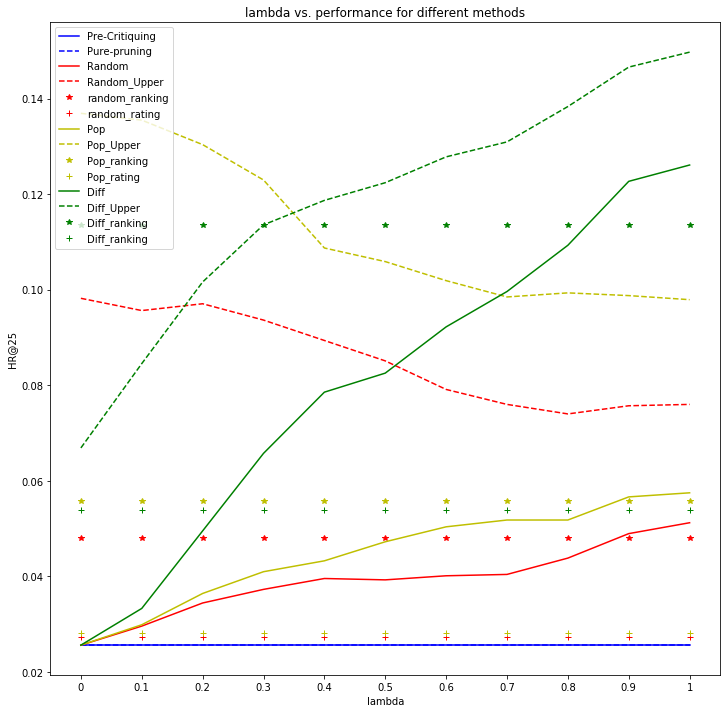

In [66]:
plot_lambda_vs_performance(df, k = 25, show = False, savefig = True, figname = "predicted_optimal_lambda.png")

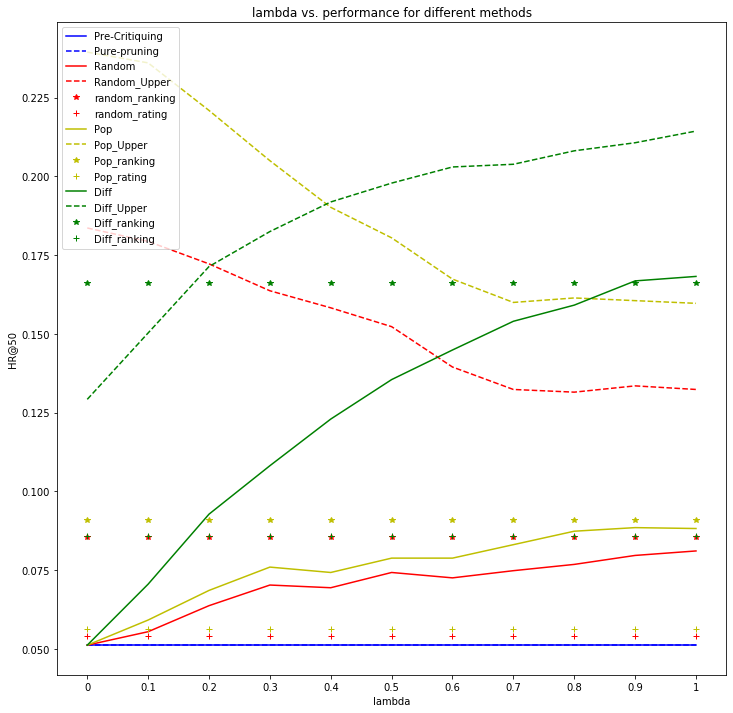

In [68]:
plot_lambda_vs_performance(df, k = 50, show = False, savefig = True, figname = "predicted_optimal_lambda_hr50.png")

In [53]:
df = pd.read_csv("../tables/critiquing/plrec_with_obj/ranking_and_rating_50user_optimal_included.csv")

In [39]:
df['diff_opti_ranking']

0     2984
1     3001
2     2735
3     3668
4     2067
      ... 
73    6796
74       9
75     155
76    7191
77      97
Name: diff_opti_ranking, Length: 78, dtype: int64

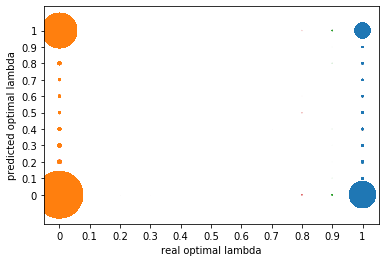

In [77]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.0001,
                                show = False, get_only_first = True, get_all = False,obj='rating',
                                savefig = True, figname = "real_vs_predicted_optimal/random_rating")

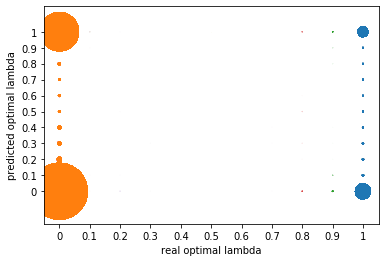

In [79]:
plot_real_predicted_best_lambda(df, rank_type1= "pop_all", rank_type2="pop",size_constant=0.0001,
                                show = False, get_only_first = True, get_all = False,obj='rating',
                                savefig = True, figname = "real_vs_predicted_optimal/pop_rating")

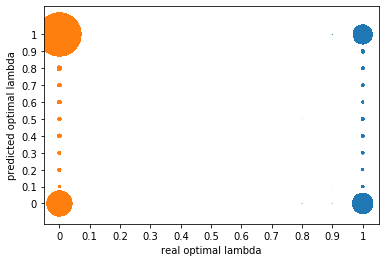

In [80]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=0.0001,
                                show = False, get_only_first = True, get_all = False,obj='rating',
                                savefig = True, figname = "real_vs_predicted_optimal/diff_rating")

### Ranking

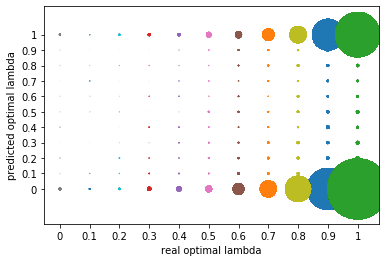

In [138]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

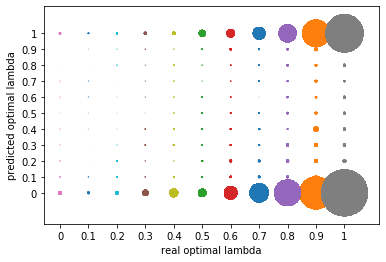

In [139]:
plot_real_predicted_best_lambda(df, rank_type1= "pop_all", rank_type2="pop",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

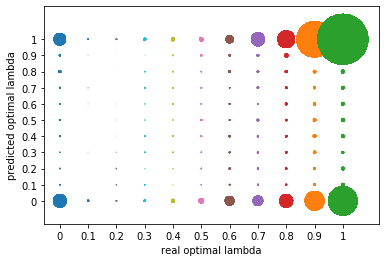

In [135]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

### Rating

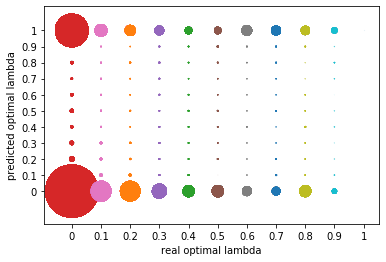

In [143]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,obj = 'rating', 
                                savefig = False, figname = None)

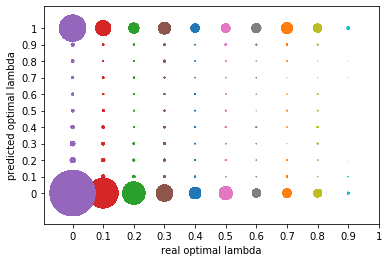

In [144]:
plot_real_predicted_best_lambda(df, rank_type1= "pop_all", rank_type2="pop",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,obj = 'rating', 
                                savefig = False, figname = None)

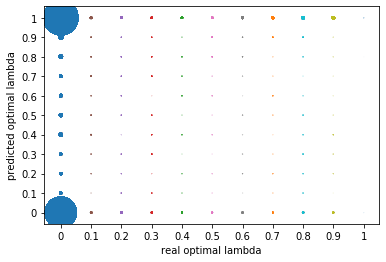

In [146]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=0.0001,
                                show = True, get_only_first = True, get_all = False,obj = 'rating', 
                                savefig = False, figname = None)

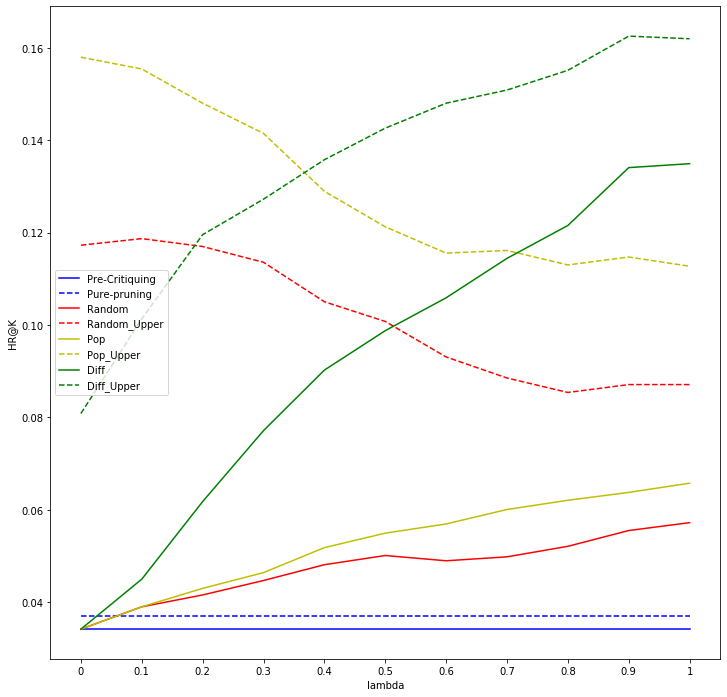

In [140]:
plot_lambda_vs_performance(df, k = 30, show = True, savefig = False)

# Test

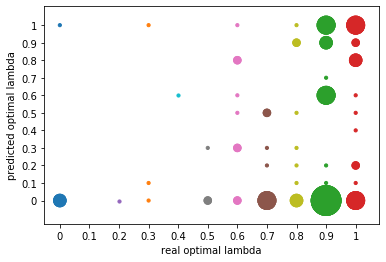

In [124]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=10,
                                show = True, get_only_first = False, get_all = False,
                                savefig = False, figname = None)

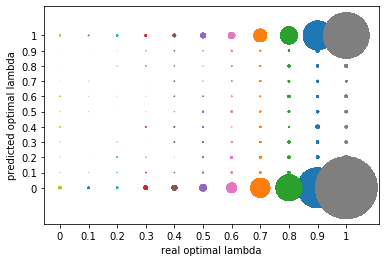

In [117]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

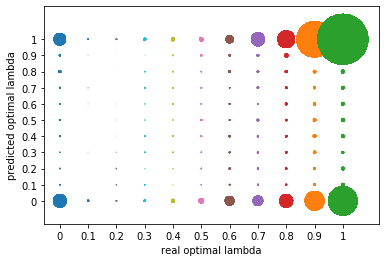

In [118]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

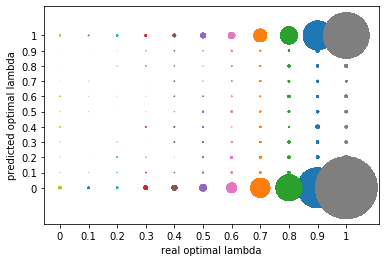

In [54]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.001,
                                show = True, 
                                savefig = False, figname = None)

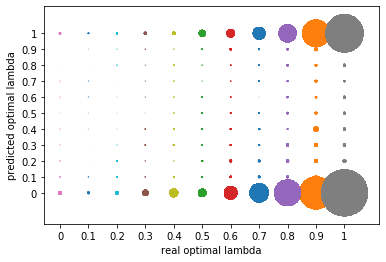

In [55]:
plot_real_predicted_best_lambda(df, rank_type1= "pop_all", rank_type2="pop",size_constant=0.001,
                                show = True, 
                                savefig = False, figname = None)

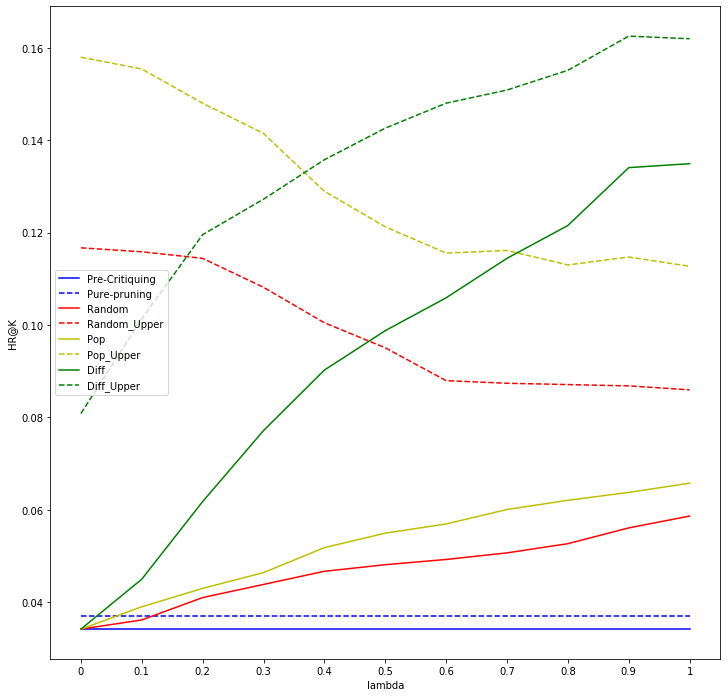

In [53]:
plot_lambda_vs_performance(df, k = 30, show = True, savefig = False)